<a href="https://colab.research.google.com/github/mavillan/jane-street-market-prediction/blob/main/train/cnn1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install -Iv scikit-learn==0.23.2 > /dev/null 2>&1
!pip install -Iv install torch-lr-finder > /dev/null 2>&1
!pip install -Iv install torchsummary > /dev/null 2>&1

In [3]:
import copy
import os
import numpy as np 
import pandas as pd
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,TensorDataset,DataLoader
from torch_lr_finder import LRFinder
from torchsummary import summary

# custom modules
import sys
sys.path.append("/content/drive/MyDrive/kaggle/janestreet")
from torch_utils import Monitor, train_step, valid_step

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
set_seed(2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
def utility_score(date, weight, resp, action):
    """
    Fast computation of utility score
    """
    date = date.astype(int)
    count_i = len(np.unique(date))
    Pi = np.bincount(date, weight * resp * action)
    t = np.sum(Pi) / np.sqrt(np.sum(Pi ** 2)) * np.sqrt(250 / count_i)
    u = np.clip(t, 0, 6) * np.sum(Pi)
    return -u

In [5]:
def cat_encoder(X):
    """
    Fast one-hot encoding of feature_0
    """
    X["feature_00"] = 0
    idx00 = X.query("feature_0 == -1").index
    X.loc[idx00,"feature_00"] = 1
    
    X["feature_01"] = 0
    idx01 = X.query("feature_0 == 1").index
    X.loc[idx01,"feature_01"] = 1
    
    return X.iloc[:,1:]

In [6]:
def show_metrics(monitor):
    x = np.arange(len(monitor.train_loss))
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))
    
    ax1 = axes[0]
    ax2 = ax1.twinx()
    ax1.plot(x, monitor.train_loss, 'go-', label="train_loss")
    ax2.plot(x, monitor.train_metric, 'ro-', label="train_metric")
    plt.legend(loc="best")
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('loss')
    ax1.set_title("Training")
    plt.grid()
    
    ax1 = axes[1]
    ax2 = ax1.twinx()
    ax1.plot(x, monitor.valid_loss, 'go-', label="valid_loss")
    ax2.plot(x, monitor.valid_metric, 'ro-', label="valid_metric")
    plt.legend(loc="best")
    ax1.set_xlabel('epochs')
    ax2.set_ylabel('metric')
    ax1.set_title("Validation")
    plt.grid()
    
    plt.show()

***
### preparing the data

In [7]:
root = Path("/content/drive/MyDrive/kaggle/janestreet/preprocessing/")

train = pd.read_parquet(root/"train.parquet")
features = pd.read_parquet(root/"features.parquet")

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 143 entries, date to w4
dtypes: float32(140), int16(1), int32(1), int8(1)
memory usage: 1.3 GB


In [8]:
train = train.query("date > 85").query("weight > 0").reset_index(drop=True)

input_features = [col for col in train.columns if "feature" in col]
resp_cols = ['resp', 'resp_1', 'resp_2', 'resp_3', 'resp_4']
w_cols = ["w", "w1", "w2", "w3", "w4"]

X_dset = train.loc[:,input_features].copy()
y_dset = (train.loc[:,resp_cols] > 0).astype(int).copy()
w_dset = train.loc[:, w_cols].copy()
dwr_dset = train.loc[:, ["date","weight","resp"]].copy()

In [9]:
%%time 

with open("/content/drive/MyDrive/kaggle/janestreet/imputer/imputer_f0m1.pickle", "rb") as file:
    imputer_f0m1 = pickle.load(file)
    file.close()
    
with open("/content/drive/MyDrive/kaggle/janestreet/imputer/imputer_f0p1.pickle", "rb") as file:
    imputer_f0p1 = pickle.load(file)
    file.close()

idx_f0m1 = X_dset.query("feature_0 == -1").index
X_dset.loc[idx_f0m1, input_features[1:]] = imputer_f0m1.transform(X_dset.loc[idx_f0m1, input_features[1:]])

idx_f0p1 = X_dset.query("feature_0 ==  1").index
X_dset.loc[idx_f0p1, input_features[1:]] = imputer_f0p1.transform(X_dset.loc[idx_f0p1, input_features[1:]])

CPU times: user 45 s, sys: 7.58 s, total: 52.5 s
Wall time: 48.3 s


In [10]:
X_dset = cat_encoder(X_dset)
input_features = X_dset.columns.tolist()

***
### model definition

In [11]:
class NormalLinear(nn.Module):
    """ 
    Linear layer with normalized weights
    """
    def __init__(self, size_in, size_out, bias=True):
        super(NormalLinear, self).__init__()
        self.size_in, self.size_out = size_in, size_out
        # weights vector
        weights_v = torch.Tensor(size_out, size_in)
        nn.init.kaiming_uniform_(weights_v, a=np.sqrt(5)) 
        self.weights_v = nn.Parameter(weights_v)
        # weights magnitude
        weights_m = torch.norm(weights_v, dim=1, keepdim=True)
        self.weights_m = nn.Parameter(weights_m.clone().detach())
        
        if bias:
            bias_v = torch.Tensor(size_out)    
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(weights_v)
            bound = 1 / np.sqrt(fan_in)
            nn.init.uniform_(bias_v, -bound, bound)
            self.bias = nn.Parameter(bias_v)
        else:
            self.register_parameter('bias', None)
            
    def _compute_weights(self):
        norm_per_output = torch.norm(self.weights_v, dim=1, keepdim=True)
        return self.weights_m * torch.div(self.weights_v, norm_per_output)
            
    def forward(self, x):
        weights = self._compute_weights()
        return nn.functional.linear(x, weights, self.bias)


class CNN1D(nn.Module):
    def __init__(self, input_dim, output_dim, sign_size=16, cha_input=32, cha_hidden=32, K=2,
                 dropout_input=0.2, dropout_hidden=0.2, dropout_output=0.2):
        super(CNN1D, self).__init__()

        hidden_size = sign_size*cha_input
        sign_size1 = sign_size
        sign_size2 = sign_size//2
        output_size = (sign_size//4) * cha_hidden

        self.hidden_size = hidden_size
        self.cha_input = cha_input
        self.cha_hidden = cha_hidden
        self.K = K
        self.sign_size1 = sign_size1
        self.sign_size2 = sign_size2
        self.output_size = output_size
        self.dropout_input = dropout_input
        self.dropout_hidden = dropout_hidden
        self.dropout_output = dropout_output

        self.batch_norm1 = nn.BatchNorm1d(input_dim)
        self.dropout1 = nn.Dropout(dropout_input)
        self.dense1 = NormalLinear(input_dim, hidden_size, bias=False)

        # 1st conv layer
        self.batch_norm_c1 = nn.BatchNorm1d(cha_input)
        self.conv1 = nn.Conv1d(cha_input, cha_input*K, kernel_size = 5, stride = 1, padding=2,  groups=cha_input, bias=False)

        self.ave_po_c1 = nn.AdaptiveAvgPool1d(output_size = sign_size2)

        # 2nd conv layer
        self.batch_norm_c2 = nn.BatchNorm1d(cha_input*K)
        self.dropout_c2 = nn.Dropout(dropout_hidden)
        self.conv2 = nn.Conv1d(cha_input*K, cha_hidden, kernel_size = 3, stride = 1, padding=1, bias=False)

        # 3rd conv layer
        self.batch_norm_c3 = nn.BatchNorm1d(cha_hidden)
        self.dropout_c3 = nn.Dropout(dropout_hidden)
        self.conv3 = nn.Conv1d(cha_hidden, cha_hidden, kernel_size = 3, stride = 1, padding=1, bias=False)

        # 4th conv layer
        self.batch_norm_c4 = nn.BatchNorm1d(cha_hidden)
        self.conv4 = nn.Conv1d(cha_hidden, cha_hidden, kernel_size = 5, stride = 1, padding=2, groups=cha_hidden, bias=False)

        self.avg_po_c4 = nn.AvgPool1d(kernel_size=4, stride=2, padding=1)

        self.flt = nn.Flatten()

        self.batch_norm2 = nn.BatchNorm1d(output_size)
        self.dropout2 = nn.Dropout(dropout_output)
        self.dense2 = NormalLinear(output_size, output_dim, bias=False)

    def forward(self, x):

        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.celu(self.dense1(x))

        x = x.reshape(x.shape[0], self.cha_input, self.sign_size1)

        x = self.batch_norm_c1(x)
        x = F.relu(self.conv1(x))

        x = self.ave_po_c1(x)

        x = self.batch_norm_c2(x)
        x = self.dropout_c2(x)
        x = F.relu(self.conv2(x))
        x_s = x

        x = self.batch_norm_c3(x)
        x = self.dropout_c3(x)
        x = F.relu(self.conv3(x))

        x = self.batch_norm_c4(x)
        x = self.conv4(x)
        x =  x + x_s
        x = F.relu(x)

        x = self.avg_po_c4(x)

        x = self.flt(x)

        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = self.dense2(x)

        return x

In [12]:
class BCELabelSmoothing(nn.Module):
    def __init__(self, label_smoothing=0.0):
        super(BCELabelSmoothing, self).__init__()
        self.label_smoothing = label_smoothing
        self.bce_loss = torch.nn.functional.binary_cross_entropy_with_logits
        
    def forward(self, prediction, target, weight=None):
        target_smooth = target*(1.0 - self.label_smoothing) + 0.5*self.label_smoothing
        if weight is None:
            loss = self.bce_loss(prediction, target_smooth, reduction="mean")
        else:
            loss = self.bce_loss(prediction, target_smooth, weight, reduction="sum") / torch.sum(weight)
        return loss

bce_loss = BCELabelSmoothing(label_smoothing=1e-2)

***
### model training: 1st step

In [13]:
train_idx = train.query("date < 450").index
valid_idx = train.query("date >= 450").index

train_dset = TensorDataset(torch.tensor(X_dset.loc[train_idx].values, dtype=torch.float), 
                           torch.tensor(y_dset.loc[train_idx].values, dtype=torch.float),
                           torch.tensor(w_dset.loc[train_idx].values, dtype=torch.float),
                           torch.tensor(dwr_dset.loc[train_idx].values, dtype=torch.float),
                          )

valid_dset = TensorDataset(torch.tensor(X_dset.loc[valid_idx].values, dtype=torch.float), 
                           torch.tensor(y_dset.loc[valid_idx].values, dtype=torch.float),
                           torch.tensor(w_dset.loc[valid_idx].values, dtype=torch.float),
                           torch.tensor(dwr_dset.loc[valid_idx].values, dtype=torch.float),
                          )

dataset_sizes = {'train': len(train_dset), 'valid': len(valid_dset)}
train_dataloader = DataLoader(train_dset, batch_size=2048, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
valid_dataloader = DataLoader(valid_dset, batch_size=len(valid_dset), shuffle=False, num_workers=2, pin_memory=True, drop_last=True)

print("Number of step per epoch:", len(train_dset)//2048)

Number of step per epoch: 652


  0%|          | 0/1304 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.15E-04


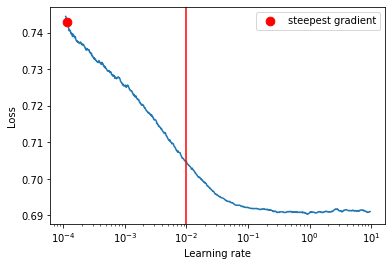

  0%|          | 0/1304 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.12E-01


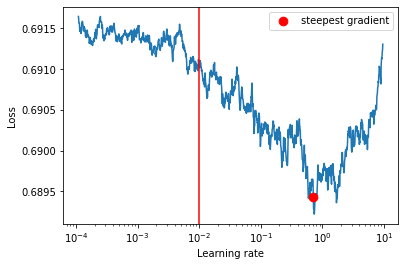

In [14]:
_model = CNN1D(input_dim=len(input_features), output_dim=len(resp_cols),
               sign_size=16, cha_input=32, cha_hidden=48, K=2,
               dropout_input=0.2, dropout_hidden=0.25, dropout_output=0.25)
_model = _model.to(device)

_optimizer = torch.optim.SGD(_model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)
lr_finder = LRFinder(_model, _optimizer, bce_loss, device="cuda")
lr_finder.range_test(train_dataloader, start_lr=1e-4, end_lr=1e1, num_iter=652*2, step_mode="exp")
lr_finder.plot(show_lr=1e-2)
plt.show()

_optimizer = torch.optim.SGD(_model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)
lr_finder = LRFinder(_model, _optimizer, bce_loss, device="cuda")
lr_finder.range_test(train_dataloader, start_lr=1e-4, end_lr=1e1, num_iter=652*2, step_mode="exp")
lr_finder.plot(show_lr=1e-2)
plt.show()

In [15]:
model = CNN1D(input_dim=len(input_features), output_dim=len(resp_cols),
              sign_size=16, cha_input=32, cha_hidden=48, K=2,
              dropout_input=0.2, dropout_hidden=0.25, dropout_output=0.25)
    
model = model.to(device)
summary(model, input_size=(len(input_features),))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm1d-1                  [-1, 131]             262
           Dropout-2                  [-1, 131]               0
      NormalLinear-3                  [-1, 512]               0
       BatchNorm1d-4               [-1, 32, 16]              64
            Conv1d-5               [-1, 64, 16]             320
 AdaptiveAvgPool1d-6                [-1, 64, 8]               0
       BatchNorm1d-7                [-1, 64, 8]             128
           Dropout-8                [-1, 64, 8]               0
            Conv1d-9                [-1, 48, 8]           9,216
      BatchNorm1d-10                [-1, 48, 8]              96
          Dropout-11                [-1, 48, 8]               0
           Conv1d-12                [-1, 48, 8]           6,912
      BatchNorm1d-13                [-1, 48, 8]              96
           Conv1d-14                [-1

In [16]:
models_history = list()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=1e-2,
    epochs=50,
    pct_start=0.1, 
    anneal_strategy='cos', 
    cycle_momentum=True, 
    base_momentum=0.8, 
    max_momentum=0.9, 
    div_factor=1e1,
    final_div_factor=1e0,
    steps_per_epoch=len(train_dataloader),
    verbose=False)

monitor = Monitor(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    patience=10,
    metric_fn=utility_score,
    experiment_name=f'cnn1d',
    num_epochs=50,
    dataset_sizes=dataset_sizes,
    early_stop_on_metric=False,
    lower_is_better=True)

for epoch in monitor.iter_epochs:
    train_step(model, train_dataloader, optimizer, monitor, bce_loss, scheduler=scheduler, clip_value=None)    
    early_stop = valid_step(model, valid_dataloader, optimizer, monitor, bce_loss)
    models_history.append(copy.deepcopy(model))
    if early_stop: break

cnn1d:   0%|          | 0/50 [00:00<?, ?it/s]

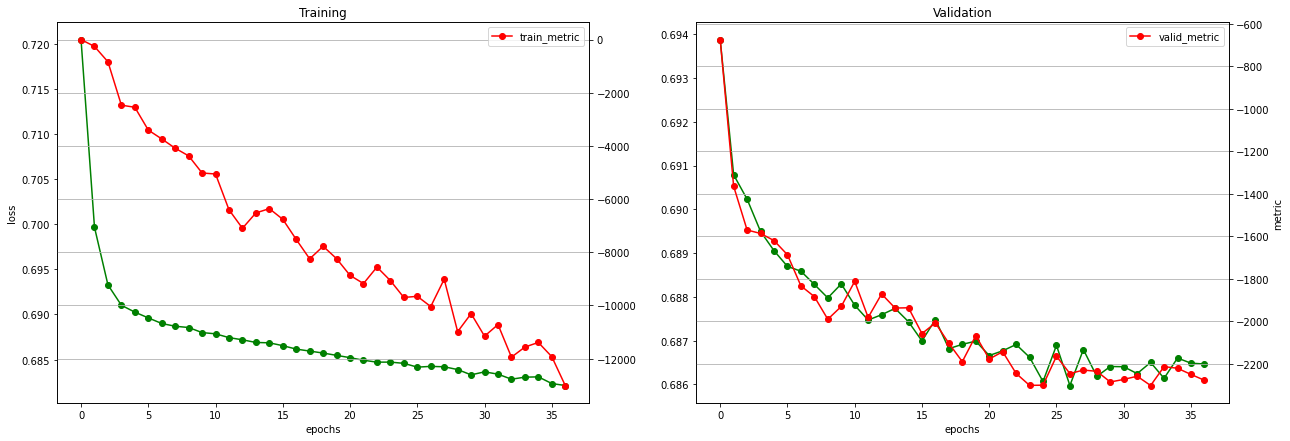

In [17]:
show_metrics(monitor)

In [18]:
# SWA around optimal on validation data
swa_model = torch.optim.swa_utils.AveragedModel(model)

for _model in models_history[26:]:
    swa_model.update_parameters(_model)
    
torch.optim.swa_utils.update_bn(train_dataloader, swa_model, device=device)

In [21]:
# puts state_dict of SWA in the format of original model
state_dict = OrderedDict()
state_dict_swa = swa_model.state_dict()

for key,params in state_dict_swa.items():
    if key == "n_averaged": continue
    key = key.replace("module.","")
    state_dict[key] = params
    
# restore model to best averaged state
model.load_state_dict(state_dict)

<All keys matched successfully>

***
### model training: 2nd step

In [22]:
train_idx = train.query("date < 450").index
valid_idx = train.query("date >= 450").index

train_dset = TensorDataset(torch.tensor(X_dset.loc[:].values, dtype=torch.float), 
                           torch.tensor(y_dset.loc[:].values, dtype=torch.float),
                           torch.tensor(w_dset.loc[:].values, dtype=torch.float),
                           torch.tensor(dwr_dset.loc[:].values, dtype=torch.float),
                          )

valid_dset = TensorDataset(torch.tensor(X_dset.loc[valid_idx].values, dtype=torch.float), 
                           torch.tensor(y_dset.loc[valid_idx].values, dtype=torch.float),
                           torch.tensor(w_dset.loc[valid_idx].values, dtype=torch.float),
                           torch.tensor(dwr_dset.loc[valid_idx].values, dtype=torch.float),
                          )

dataset_sizes = {'train': len(train_dset), 'valid': len(valid_dset)}
train_dataloader = DataLoader(train_dset, batch_size=2048, shuffle=True, num_workers=2)
valid_dataloader = DataLoader(valid_dset, batch_size=len(valid_dset), shuffle=False, num_workers=2)

print("Number of step per epoch:", len(train_dset)//2048)

Number of step per epoch: 767


  0%|          | 0/2608 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.36E-04


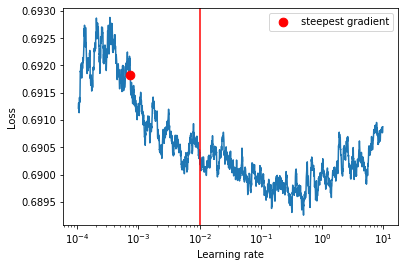

In [23]:
_optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9, weight_decay=1e-4)
lr_finder = LRFinder(model, _optimizer, bce_loss, device="cuda")
lr_finder.range_test(train_dataloader, start_lr=1e-4, end_lr=1e1, num_iter=652*4, step_mode="exp")
lr_finder.plot(show_lr=1e-2)
plt.show()

In [24]:
# restore to state of best epoch
model.load_state_dict(state_dict)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-4)

In [25]:
swa_model = torch.optim.swa_utils.AveragedModel(model)
swa_model = swa_model.to(device)
scheduler = torch.optim.swa_utils.SWALR(optimizer, swa_lr=1e-2, anneal_strategy="cos", anneal_epochs=5)

models_history = list()

monitor = Monitor(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    patience=15,
    metric_fn=utility_score,
    experiment_name=f'CNN1D',
    num_epochs=15,
    dataset_sizes=dataset_sizes,
    early_stop_on_metric=False,
    lower_is_better=True)

for epoch in monitor.iter_epochs:
    train_step(model, train_dataloader, optimizer, monitor, bce_loss, scheduler=None, clip_value=None)    
    valid_step(model, valid_dataloader, optimizer, monitor, bce_loss)
    scheduler.step()
    
    models_history.append(copy.deepcopy(model))

CNN1D:   0%|          | 0/15 [00:00<?, ?it/s]

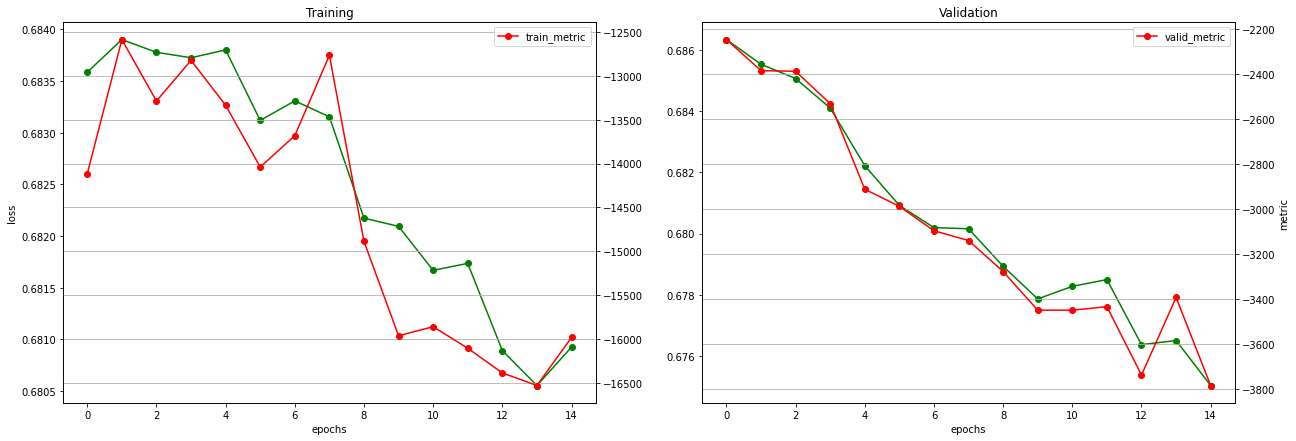

In [26]:
show_metrics(monitor)

In [27]:
# SWA around optimal on validation data
start_epoch = 5
end_epoch = 14

for _model in models_history[start_epoch:end_epoch+1]:
    swa_model.update_parameters(_model)
    
torch.optim.swa_utils.update_bn(train_dataloader, swa_model, device=device)

***